In [1]:
%matplotlib inline
import fsps
import matplotlib.pyplot as plt
import numpy as np

* add_igm_absorption includes IGM absorption via Madau 1995
* zred is redshift
* zmet = 1.0 by default, metallicity 
* sfh = 0 is SSP model (all stars have same age and metallicity) 
* tage = Myr age
* sfh = tabular sfr per year since big bang
* dust_type = 2; See Calzetti et al 2000. Dust attenuation is applied to all starlight equally (old and new). This is set by dust_2
* dust_2 small attenuation due to ISM dust for all stars. 

In [2]:
sp = fsps.StellarPopulation(zred=3., const=1.0, sfh=3, tage=0.5, add_igm_absorption=True, zmet = 1., dust1=0.0, dust2=0.1, dust_type=2 )

Create arrays of age since big bang in Gyr and the constant star formation rate of 5 solar mass / yr.

In [3]:
a = np.arange(0.1, 0.6, 0.1)
sfr = np.full(5, 5.0)

Set the star formation history with a constant star formation rate.

In [4]:
sp.set_tabular_sfh(age = a, sfr = sfr)

Below we print the AB magnitudes in desired bands. They are extremely faint right now and I think this is because the star formation rate is by default normalized to 1. I need to figure out how to make it 5. 

In [5]:
mags = sp.get_mags(zmet = 1., tage=0.5, bands=['wfc_acs_f435w', 'wfc_acs_f606w', 'wfc_acs_f775w', 'wfc_acs_f850lp', 'wfc3_ir_f105w', 'wfc3_ir_f125w', 'wfc3_ir_f160w', 'jwst_f200w', 'jwst_f277w', 'jwst_f356w', 'jwst_f444w'])
print 'HST F435W: ', mags[0]
print 'HST F606W: ', mags[1]
print 'HST F775W: ', mags[2]
print 'HST F850LP: ', mags[3]
print 'HST F105W: ', mags[4]
print 'HST F125W: ', mags[5]
print 'HST F160W: ', mags[6]
print 'JWST F200W: ', mags[7]
print 'JWST F277W: ', mags[8]
print 'JWST F356W: ', mags[9]
print 'JWST F444W: ', mags[10]

HST F435W:  25.6851805867
HST F606W:  25.194646169
HST F775W:  25.2455911011
HST F850LP:  25.3137045312
HST F105W:  25.3833653941
HST F125W:  25.4682002621
HST F160W:  25.3068973513
JWST F200W:  25.2950060402
JWST F277W:  25.4801908025
JWST F356W:  25.5670115285
JWST F444W:  25.6415406807


In [6]:
wave, spec = sp.get_spectrum(zmet = 1., tage = 0.5)

In [7]:
#convert angstroms to m
wave_m = wave * (1.0E-10)

Divide spectrum to get in $\mu$Jy.

In [8]:
spec = spec * (3.828E26) # convert solar luminosity to W

In [9]:
spec = spec / (wave_m**2) # divide by wavelength in meters ^2

In [10]:
spec = spec / (1.0E-26) # 1 Jy = 10^-26 W/Hz/m^2

In [11]:
spec = spec / (1.0E-6) # convert to microJy

(1e+54, 1e+70)

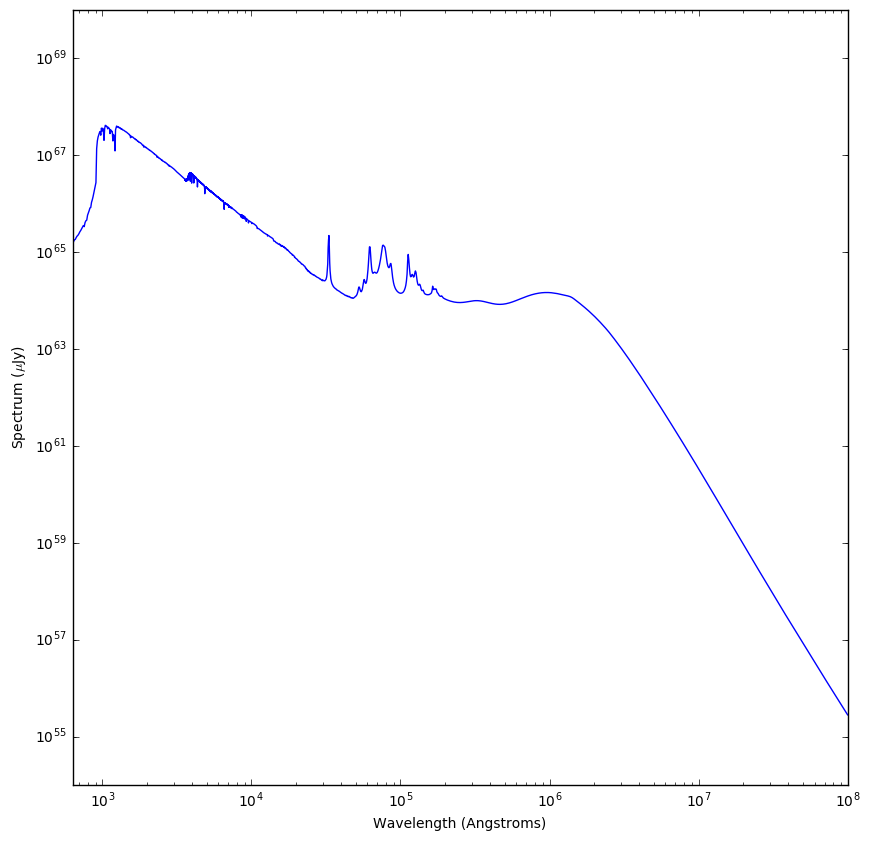

In [16]:
fig = plt.figure(figsize=[10,10])
plt.plot(wave, spec)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Spectrum ($\mu$Jy)')
plt.xlim(1.0*10**2.8,1.0E8)
plt.ylim(1.0E54,1.0E70)